# Baseline model - simple MLP


Imports:

In [2]:
import copy
import pandas as pd
import numpy as np
import pathlib
import os
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

read data:

In [3]:
df_hard = pd.read_excel('all_data_long.xlsx')

In [4]:
df_hard['Fictive ID'].nunique()

36240

In [51]:
all_df = copy.deepcopy(df_hard)
all_df.columns = all_df.columns.str.replace("'", "")

features_to_start = ['year', 'מין', 'סוג פיקוח', ' פסיכומטרי רב תחומי', 'פסיכומטרי כמותי', 'פסיכומטרי מילולי',
               'שפת פסיכומטרי', 'בגרות', 'ציון מכינה', 'ניקוד רל"ק', 'שנת לידה', 'פקולטה', 'חוג', 'מסלול', 'משקולל קיים', 'נשר חיצונית']

df = all_df[features_to_start]

feature_names_to_replace = {"מין": "gender", 'סוג פיקוח': 'supervision_type',
                        ' פסיכומטרי רב תחומי': 'psico_rav', 'פסיכומטרי כמותי':'psico_camul',
                        'פסיכומטרי מילולי':'psico_verb', 'שפת פסיכומטרי': 'psico_leng',
                        'בגרות':'bag', 'ציון מכינה':'preparatory_score', 'ניקוד רל"ק':'ralak_score',
                        'שנת לידה':'birth_year', 'פקולטה':'faculty',
                        'חוג':'hug', 'מסלול':'study_track', 'משקולל קיים':'weighted_score', 'נשר חיצונית':'dropouts'}

df = df.rename(columns=feature_names_to_replace)

features_to_start_id = features_to_start.copy()
features_to_start_id.append('Fictive ID')
df_id = all_df[features_to_start_id]
df_id = df_id.rename(columns=feature_names_to_replace)

split to train and test:

In [6]:
def split_train_test(df):
    X = df.drop('dropouts', axis=1)
    Y = df['dropouts'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)
    
    # Reset indices for compatibility
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = pd.Series(y_train).reset_index(drop=True)
    y_test = pd.Series(y_test).reset_index(drop=True)
    return X_train, X_test, y_train, y_test

build base model:

In [7]:
class DropuotsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features.iloc[idx].values, dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }


In [8]:
class BaseModelNN(nn.Module):
    def __init__(self, input_dim):
        super(BaseModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 12)
        self.fc2 = nn.Linear(12, 6)
        self.output = nn.Linear(6, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x

training loop:

In [9]:
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    model.to(device)  # Move model to the specified device (CPU or GPU)

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for batch in train_loader:
            # Move data to the same device as the model
            features = batch['features'].to(device)
            labels = batch['label'].to(device).view(-1, 1)  # Ensure labels are shaped as (batch_size, 1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")

## Baseline:

take only numeric features, drop duplicates:

In [10]:
numeric_features = df.select_dtypes(include=['number']).columns
# drop hug column:
numeric_features = numeric_features[~numeric_features.str.fullmatch('hug')]
# drop duplicates
numeric_df = df[numeric_features].drop_duplicates()
# train test split:
X_train, X_test, y_train, y_test = split_train_test(numeric_df)

In [11]:
# Create DataLoader
batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

initialize model and optimizer:

In [21]:
model = BaseModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

train:

In [22]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 5.4716
Epoch [2/10], Loss: 5.4100
Epoch [3/10], Loss: 5.4104
Epoch [4/10], Loss: 5.4096
Epoch [5/10], Loss: 5.4104
Epoch [6/10], Loss: 5.4104
Epoch [7/10], Loss: 5.4121
Epoch [8/10], Loss: 5.4113
Epoch [9/10], Loss: 5.4096
Epoch [10/10], Loss: 5.4100
Training complete.


evaluation:

In [23]:
def evaluate_model(model, data_loader, criterion, device, threshold=0.05):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            # Move data to the same device as the model
            features = batch['features'].to(device)
            labels = batch['label'].to(device).view(-1, 1)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions and probabilities
            probabilities = outputs.squeeze().cpu().numpy()  # Convert to numpy array
            predictions = (probabilities >= threshold).astype(int)  # Threshold for binary classification
            labels = labels.cpu().numpy()  # Convert labels to numpy

            # Store results
            all_labels.extend(labels)
            all_predictions.extend(predictions)
            all_probs.extend(probabilities)

    # Compute average loss
    avg_loss = total_loss / len(data_loader)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f"Evaluation Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return {'loss': avg_loss,
            'accuracy_score': accuracy,
            'precision_score': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'lables': all_labels,
            'predictions': all_predictions,
            'probabilities': all_probs}


In [24]:
test_eval_results = evaluate_model(model, test_loader, criterion, device)

100%|██████████| 264/264 [00:00<00:00, 329.96it/s]

Evaluation Results:
Loss: 5.6593
Accuracy: 0.9434
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000



c:\Users\nadavkat\OneDrive - Intel Corporation\Documents\Learning\University\University-Dropouts-Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
np.unique(test_eval_results['probabilities'])

array([0.], dtype=float32)

this model practically predicts all students will not drop. this is obviousley not good.

# Enhancements: 
change stochastic gradient decent fetchers to dill with the unbalances df

learning rate from 0.1 to 0.01, 

set weight decay 0.005

change the threshold for binary classification from 0.5 to mean(y_train)

In [28]:
batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = BaseModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

threshold = np.round(y_train.mean(), 3)
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=threshold)

Epoch [1/10], Loss: 94.5849
Epoch [2/10], Loss: 94.5841
Epoch [3/10], Loss: 94.5833
Epoch [4/10], Loss: 94.5846
Epoch [5/10], Loss: 94.5841
Epoch [6/10], Loss: 94.5841
Epoch [7/10], Loss: 94.5841
Epoch [8/10], Loss: 94.5846
Epoch [9/10], Loss: 94.5829
Epoch [10/10], Loss: 94.5841
Training complete.


100%|██████████| 264/264 [00:01<00:00, 249.32it/s]


Evaluation Results:
Loss: 94.3407
Accuracy: 0.0566
Precision: 0.0566
Recall: 1.0000
F1 Score: 0.1071
ROC AUC: 0.5000


In [29]:
set(test_eval_results['probabilities'])

{np.float32(1.0)}

# Enhancements: 
change the model architecture and preprocess data to achive better results

## add layers and neurons:

In [31]:
class MLPModelNN(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x


batch_size = 32
train_dataset = DropuotsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = MLPModelNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [32]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 0.2274
Epoch [2/10], Loss: 0.2118
Epoch [3/10], Loss: 0.2119
Epoch [4/10], Loss: 0.2120
Epoch [5/10], Loss: 0.2119
Epoch [6/10], Loss: 0.2120
Epoch [7/10], Loss: 0.2119
Epoch [8/10], Loss: 0.2118
Epoch [9/10], Loss: 0.2120
Epoch [10/10], Loss: 0.2119
Training complete.


In [33]:
threshold = np.round(y_train.mean(), 3)
print('threshold:', threshold)

threshold: 0.054


In [34]:
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=threshold)

100%|██████████| 264/264 [00:00<00:00, 303.55it/s]


Evaluation Results:
Loss: 0.2188
Accuracy: 0.0566
Precision: 0.0566
Recall: 1.0000
F1 Score: 0.1071
ROC AUC: 0.5000


In [35]:
# sum(test_eval_results['predictions'])/len(test_eval_results['predictions'])
set(test_eval_results['probabilities'])

{np.float32(0.069253765)}

It seems like adding layers dosent solve the problem, and the model is still not preforming well. also, the model just predict a single value for all observations. 

## preprocess data:
The data preprocess is based on knowledge about this specific usecase and data, as revised by an SME
we scaled the data with the following:
1. create scaler for each hug & year in the training set
2. create MinMaxScaler for year & age
3. scale train & test using the scaler learned on the train
4. for hug & year not in training - use a scaler learned on the entire train set

In [36]:
def preprocess_data(data, scaler_by_group=None, year_scaler=None, train_scaler=None, test_mode=False):
    df = data.copy()
    
    # remove samples with 0 bagrut score:
    df = df[df['bag'] != 0]# remove 1252 samples
    
    # df['supervision_type'] = np.where(df['supervision_type'].isna(), 'missing', df['supervision_type'])
    
    # df['ralak'] = np.where(df['ralak_score'] >= 30, 1, 0)
    # df.pop('ralak_score')
    
    # learned in preparatory at huji:
    df['preparatory'] = np.where(df['preparatory_score'] > 0, 1, 0)
    # df.pop('preparatory_score')
    
    # create age feature:
    df['age'] = df['year'] - df['birth_year']
    # df.pop('birth_year')
    # df.pop('חוג')
    # df.pop('פקולטה')
    
    # encode categorical binary variables:
    df['study_track'] = np.where(df['study_track'] == 'חד חוגי', 0, 1)
    df['gender'] = np.where(df['gender'] == 'ז', 0, 1)
    
    cols_to_scale = ['psico_rav', 'psico_camul', 'psico_verb', 'bag', 'preparatory_score', 'ralak_score', 'age', 'weighted_score']    
    df.loc[:, cols_to_scale] = df[cols_to_scale].astype('float64')
    df.loc[:, ['year', 'birth_year']] = df[['year', 'birth_year']].astype('float64')
    
    groups = df.groupby(['hug_num', 'year']).groups
    
    if not test_mode:
        scaler_by_group = {group: StandardScaler().fit(df.loc[groups[group], cols_to_scale]) for group in groups.keys()}
        year_scaler = MinMaxScaler().fit(df[['year', 'birth_year']])
        train_scaler = StandardScaler().fit(df.loc[:, cols_to_scale])
    for group in groups.keys():
        if group in scaler_by_group:
            scaler = scaler_by_group[group]
            df.loc[groups[group], cols_to_scale] = scaler.transform(df.loc[groups[group], cols_to_scale])
        else:
            df.loc[groups[group], cols_to_scale] = train_scaler.transform(df.loc[groups[group], cols_to_scale])
            
    
    df[['year', 'birth_year']] = year_scaler.transform(df[['year', 'birth_year']])
    
    if not test_mode:
        return df, scaler_by_group, year_scaler, train_scaler
    else:
        return df

In [59]:
df = df[df['bag'] != 0]# remove 1252 samples
df_prep = copy.deepcopy(df)

df_prep = df_prep.drop('psico_leng', axis=1)
df_prep = df_prep.drop('supervision_type', axis=1)
df_prep['hug_num'] = df['hug']

df_prep = pd.get_dummies(df_prep, columns=['hug', 'faculty'], dtype=float)

X_train, X_test, y_train, y_test = split_train_test(df_prep)
X_train, scaler_by_group, year_scaler, train_scaler = preprocess_data(X_train, test_mode=False)

X_train = X_train.drop('hug_num', axis=1)

X_test = preprocess_data(X_test, scaler_by_group=scaler_by_group, year_scaler=year_scaler, train_scaler=train_scaler, test_mode=True)
X_test = X_test.drop('hug_num', axis=1)


C:\Users\nadavkat\AppData\Local\Temp\ipykernel_23592\3474564085.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.61723291  0.23009568  0.51336683 -0.78968043  0.5558575   0.47087615
 -0.22313815  0.51808801  0.37645244  0.33868295  0.65972358  0.47559734
  0.78247441 -2.72064539  0.5228092  -0.19481103 -2.72064539  0.21593213
  0.37173125]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[groups[group], cols_to_scale] = scaler.transform(df.loc[groups[group], cols_to_scale])
C:\Users\nadavkat\AppData\Local\Temp\ipykernel_23592\3474564085.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.63629224  0.25819076  0.51025841 -0.5416393   0.57327532  0.5005635
 -0.26533437  0.56358041  0.25819076  0.20971621  0.65568206  0.41330931
  0.88351244 -2.73268891  0.45208895 -

In [60]:
# Create DataLoader
numeric_features = X_train.select_dtypes(include=['number']).columns

batch_size = 32
train_dataset = DropuotsDataset(X_train[numeric_features], y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DropuotsDataset(X_test[numeric_features], y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

try MLP again with scailing:

In [61]:
class MLPModelNN(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)
        self.fc5 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)

    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))  # For binary classification
        return x


model = MLPModelNN(input_dim=X_train[numeric_features].shape[1])
criterion = nn.BCELoss()  # For binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.005)

In [62]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 0.2760
Epoch [2/10], Loss: 0.2142
Epoch [3/10], Loss: 0.2085
Epoch [4/10], Loss: 0.2072
Epoch [5/10], Loss: 0.2067
Epoch [6/10], Loss: 0.2068
Epoch [7/10], Loss: 0.2065
Epoch [8/10], Loss: 0.2065
Epoch [9/10], Loss: 0.2065
Epoch [10/10], Loss: 0.2065
Training complete.


In [63]:
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=0.05)

100%|██████████| 340/340 [00:05<00:00, 66.74it/s]


Evaluation Results:
Loss: 0.2089
Accuracy: 0.0535
Precision: 0.0532
Recall: 1.0000
F1 Score: 0.1010
ROC AUC: 0.4788


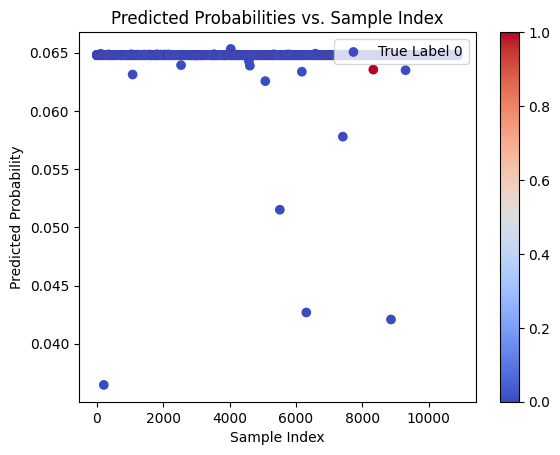

In [64]:
# plot the probabilities of the model and color each point by the true label, and add legend to the plot:
plt.scatter(range(len(test_eval_results['probabilities'])), test_eval_results['probabilities'], c=test_eval_results['lables'], cmap='coolwarm')
plt.colorbar()
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities vs. Sample Index')
plt.legend(['True Label 0', 'True Label 1'], loc='upper right')
plt.show()


maybe add class weight and use BCEWithLogitLoss, need to add pos_weight argument. 

## locally connected:
Add weight dropouts and local connection to encode one hot encoded categorical variables:

In [144]:
import torch.nn.functional as F

class EnhancedMLPModelNN(nn.Module):
    def __init__(self, input_dim, one_hot_idx, one_hot_dim):
        super(EnhancedMLPModelNN, self).__init__()
        
        # Locally connected layer for one-hot encoded features
        self.local_fc = nn.Sequential(nn.Linear(sum(one_hot_idx), one_hot_dim*2), 
                                      nn.LeakyReLU(),
                                      nn.Linear(one_hot_dim*2, one_hot_dim))
        self.input_dim = input_dim
        self.one_hot_dim = one_hot_dim
        self.one_hot_idx = one_hot_idx
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim - sum(one_hot_idx) + one_hot_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        self.fc6 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)
        
        # Projection layers for skip connections
        self.projection1 = nn.Linear(64, 32)  # Project 64-dim (x1) to 32-dim (x2)
        self.projection2 = nn.Linear(64, 8)   # Project 16-dim (x1) to 8-dim (x3)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)

    def forward(self, features):
        # Split features into numeric and one-hot parts
        numeric_features = features[:, ~self.one_hot_idx]
        one_hot_features = features[:, self.one_hot_idx]

        # Process one-hot encoded features with a locally connected layer
        one_hot_out = F.relu(self.local_fc(one_hot_features))
        
        # Concatenate back the numeric features
        x = torch.cat((numeric_features, one_hot_out), dim=1)

        # Forward pass with skip connections
        x1 = F.relu(self.fc1(x))
        x1 = self.dropout1(x1)

        x2 = F.relu(self.fc2(x1))
        x_projected1 = self.projection1(x1)  # Project x1 to match the dimensions of x2
        x2 = self.dropout2(x2 + x_projected1)  # Skip connection

        x3 = F.relu(self.fc3(x2))

        x4 = F.relu(self.fc4(x3))
        x_projected2 = self.projection2(x1)  # Project x2 to match the dimensions of x3
        x4 = self.dropout3(x4 + x_projected2)  # Skip connection

        x5 = F.relu(self.fc5(x4))
        x6 = F.relu(self.fc6(x5))

        # Output layer
        output = torch.sigmoid(self.output(x6))
        
        return output


In [145]:
one_hot_idx = np.where(X_train.columns.str.startswith('hug') | X_train.columns.str.startswith('faculty'))[0]
one_hot_idx = X_train.columns.str.startswith('hug') | X_train.columns.str.startswith('faculty')

In [146]:
len(one_hot_idx), sum(one_hot_idx)

(144, np.int64(131))

In [147]:
model = EnhancedMLPModelNN(input_dim=X_train.shape[1], one_hot_idx=one_hot_idx, one_hot_dim=8)
criterion = nn.MSELoss()  # For binary classification
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)

In [149]:
train_model(model, train_loader, criterion, optimizer, epochs=10, device=device)

Epoch [1/10], Loss: 0.0578
Epoch [2/10], Loss: 0.0494
Epoch [3/10], Loss: 0.0490
Epoch [4/10], Loss: 0.0486
Epoch [5/10], Loss: 0.0484
Epoch [6/10], Loss: 0.0483
Epoch [7/10], Loss: 0.0482
Epoch [8/10], Loss: 0.0482
Epoch [9/10], Loss: 0.0482
Epoch [10/10], Loss: 0.0481
Training complete.


In [150]:
test_eval_results = evaluate_model(model, test_loader, criterion, device, threshold=0.05)

100%|██████████| 340/340 [00:04<00:00, 79.91it/s]


Evaluation Results:
Loss: 0.0493
Accuracy: 0.4985
Precision: 0.0752
Recall: 0.7457
F1 Score: 0.1365
ROC AUC: 0.6790


this is better!

In [152]:
model

EnhancedMLPModelNN(
  (local_fc): Sequential(
    (0): Linear(in_features=131, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (fc1): Linear(in_features=21, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=4, bias=True)
  (fc6): Linear(in_features=4, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
  (projection1): Linear(in_features=64, out_features=32, bias=True)
  (projection2): Linear(in_features=64, out_features=8, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
)

## another option: 

In [157]:
import torch.nn.functional as F

class EnhancedMLPModelNN(nn.Module):
    def __init__(self, input_dim, one_hot_idx, one_hot_dim):
        super(EnhancedMLPModelNN, self).__init__()
        
        # Locally connected layer for one-hot encoded features
        self.local_fc = nn.Sequential(nn.Linear(sum(one_hot_idx), one_hot_dim*2), 
                                      nn.LeakyReLU(),
                                      nn.Linear(one_hot_dim*2, one_hot_dim))
        self.input_dim = input_dim
        self.one_hot_dim = one_hot_dim
        self.one_hot_idx = one_hot_idx
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim - sum(one_hot_idx) + one_hot_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        self.fc6 = nn.Linear(4, 2)
        self.output = nn.Linear(2, 1)
        
        # Projection layers for skip connections
        self.projection1 = nn.Linear(64, 32)  # Project 64-dim (x1) to 32-dim (x2)
        self.projection2 = nn.Linear(64, 8)   # Project 16-dim (x1) to 8-dim (x3)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.1)

    def forward(self, features):
        # Split features into numeric and one-hot parts
        numeric_features = features[:, ~self.one_hot_idx]
        one_hot_features = features[:, self.one_hot_idx]

        # Process one-hot encoded features with a locally connected layer
        one_hot_out = F.relu(self.local_fc(one_hot_features))
        
        # Concatenate back the numeric features
        x = torch.cat((numeric_features, one_hot_out), dim=1)

        # Forward pass with skip connections
        x1 = F.leaky_relu(self.fc1(x))
        x1 = self.dropout1(x1)

        x2 = F.leaky_relu(self.fc2(x1))
        x_projected1 = self.projection1(x1)  # Project x1 to match the dimensions of x2
        x2 = self.dropout2(x2 + x_projected1)  # Skip connection

        x3 = F.leaky_relu(self.fc3(x2))

        x4 = F.leaky_relu(self.fc4(x3))
        x_projected2 = self.projection2(x1)  # Project x1 to match the dimensions of x4
        x4 = self.dropout3(x4 + x_projected2)  # Skip connection

        x5 = F.leaky_relu(self.fc5(x4))
        x6 = F.leaky_relu(self.fc6(x5))

        # Output layer
        output = torch.sigmoid(self.output(x6))
        
        return output


In [163]:
model1 = EnhancedMLPModelNN(input_dim=X_train.shape[1], one_hot_idx=one_hot_idx, one_hot_dim=16)
criterion = nn.MSELoss()  # For binary classification
optimizer = optim.AdamW(model1.parameters(), lr=0.001, weight_decay=0.005)

train_model(model1, train_loader, criterion, optimizer, epochs=10, device=device)

test_eval_results = evaluate_model(model1, test_loader, criterion, device, threshold=0.05)

Epoch [1/10], Loss: 0.0519
Epoch [2/10], Loss: 0.0488
Epoch [3/10], Loss: 0.0485
Epoch [4/10], Loss: 0.0484
Epoch [5/10], Loss: 0.0482
Epoch [6/10], Loss: 0.0482
Epoch [7/10], Loss: 0.0482
Epoch [8/10], Loss: 0.0482
Epoch [9/10], Loss: 0.0481
Epoch [10/10], Loss: 0.0480
Training complete.


100%|██████████| 340/340 [00:05<00:00, 67.91it/s]


Evaluation Results:
Loss: 0.0489
Accuracy: 0.5868
Precision: 0.0831
Recall: 0.6747
F1 Score: 0.1480
ROC AUC: 0.6842


In [166]:
torch.save(model.state_dict(), 'model.pkl')

evaluate using existing model: 

In [167]:
model = EnhancedMLPModelNN(input_dim=X_train.shape[1], one_hot_idx=one_hot_idx, one_hot_dim=8)
model.load_state_dict(torch.load('model.pkl', weights_only=True))
model.eval()

EnhancedMLPModelNN(
  (local_fc): Sequential(
    (0): Linear(in_features=131, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (fc1): Linear(in_features=21, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=4, bias=True)
  (fc6): Linear(in_features=4, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
  (projection1): Linear(in_features=64, out_features=32, bias=True)
  (projection2): Linear(in_features=64, out_features=8, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
)